In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
df = pd.read_csv("HireSense_Employee_Attrition_Data.csv", encoding='utf-8')

In [4]:
def reading_cleaning(df):
    df.columns = [x.lower() for x in df.columns]
    df.drop_duplicates(inplace=True)
    return df

df = reading_cleaning(df)

In [6]:
def employee_important_info(df):
    average_satisfaction = df['satisfaction_level'].mean()
    department_satisfaction = df.groupby('department')['satisfaction_level'].mean()
    salary_satisfaction = df.groupby('salary')['satisfaction_level'].mean()
    left_employees = len(df[df['left'] == 1])
    stayed_employees = len(df[df['left'] == 0])
    return average_satisfaction, department_satisfaction, salary_satisfaction, left_employees, stayed_employees

avg_sat, dept_sat, sal_sat, left, stayed = employee_important_info(df)
print(f"Average Satisfaction Level: {avg_sat}")
print("Department-wise Satisfaction:\n", dept_sat)
print("Salary-wise Satisfaction:\n", sal_sat)
print(f"Employees who left: {left}")
print(f"Employees who stayed: {stayed}")

Average Satisfaction Level: 0.6025083272990586
Department-wise Satisfaction:
 department
IT             0.596568
RandD          0.606976
accounting     0.578370
hr             0.595282
management     0.599833
marketing      0.605653
product_mng    0.607022
sales          0.601585
support        0.614926
technical      0.601670
Name: satisfaction_level, dtype: float64
Salary-wise Satisfaction:
 salary
h         0.240000
high      0.627799
low       0.592670
medium    0.610444
Name: satisfaction_level, dtype: float64
Employees who left: 1991
Employees who stayed: 4914


In [7]:
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['department', 'salary'], drop_first=True)

In [8]:
X = df_encoded.drop('left', axis=1)
y = df_encoded['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

C:\Users\subas\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:48:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of XGBoost Model: {accuracy:.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy of XGBoost Model: 96.09%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       960
           1       0.98      0.89      0.93       421

    accuracy                           0.96      1381
   macro avg       0.97      0.94      0.95      1381
weighted avg       0.96      0.96      0.96      1381

Confusion Matrix:
 [[952   8]
 [ 46 375]]


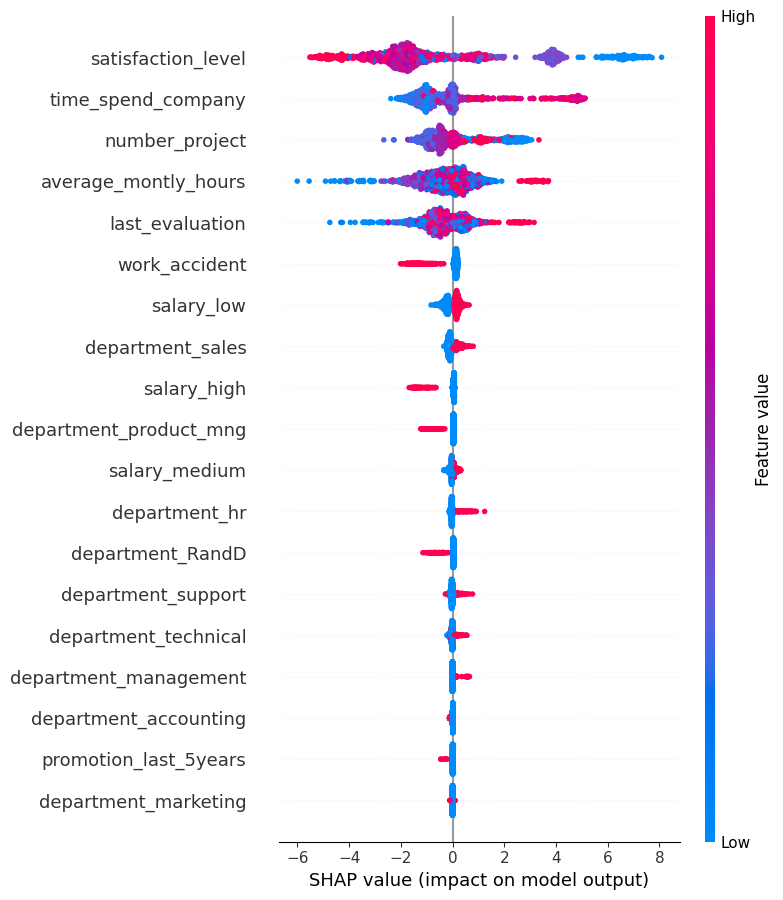

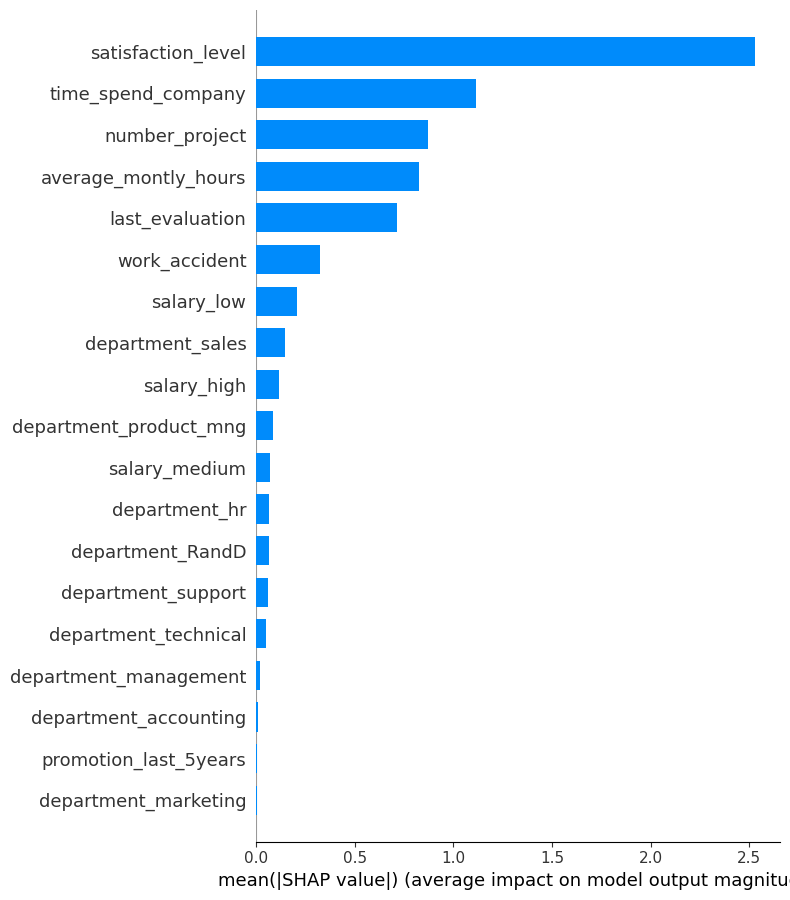

In [11]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [13]:
import pickle
with open("xgb_employee_attrition.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

In [19]:
import pandas as pd
import pickle

with open("xgb_employee_attrition.pkl", "rb") as f:
    model = pickle.load(f)

expected_columns = [
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company', 'work_accident',
    'promotion_last_5years', 'department_RandD', 'department_accounting',
    'department_hr', 'department_management', 'department_marketing',
    'department_product_mng', 'department_sales', 'department_support',
    'department_technical', 'salary_high', 'salary_low', 'salary_medium'
]

def predict_employee_attrition(input_data):
    """
    Predicts whether an employee will leave or stay using XGBoost.
    input_data: DataFrame with raw employee data (categorical columns included).
    Returns: 0 (stay) or 1 (leave)
    """
    input_data = input_data.copy()
    input_data = pd.get_dummies(input_data, columns=['department', 'salary'])
    for col in expected_columns:
        if col not in input_data.columns:
            input_data[col] = 0
    input_data = input_data[expected_columns]
    prediction = model.predict(input_data)
    return prediction

new_employee = pd.DataFrame({
    'satisfaction_level': [0.6],
    'last_evaluation': [0.75],
    'number_project': [4],
    'average_montly_hours': [230],
    'time_spend_company': [4],
    'work_accident': [0],
    'promotion_last_5years': [0],
    'department': ['sales'],
    'salary': ['medium']
})
print("Prediction:", predict_employee_attrition(new_employee))

Prediction: [0]
